In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from graphload import graphload
from auc_all_methods import similarity_indices

In [2]:
G, df, X, Y = graphload("usair97.gml")
X = np.asarray(X).astype('float32')
Y = np.asarray(Y).astype('float32')
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

In [3]:
df

,Edges,CN,LHN2,CBL,MFI,y
0,"(Pago Pago Intl, Los Angeles Intl)",1,3.613812,0.100417,0.008660,1
1,"(Pago Pago Intl, Honolulu Intl)",1,8.881958,0.167910,0.018284,1
2,"(Babelthuap/Koror, Guam Intll)",1,53.280784,0.787553,0.134374,1
3,"(Babelthuap/Koror, Saipan Intl)",1,53.280784,0.803168,0.145380,1
4,"(Guam Intll, Honolulu Intl)",0,4.429884,0.176837,0.013916,1
...,...,...,...,...,...,...
4247,"(Dallas Love Field, John F Kennedy Intl)",2,0.004110,0.062360,0.003598,0
4248,"(New Hanover Intll, University Of Illinois-Wil...",0,0.001715,0.005161,0.002310,0
4249,"(Ontario Intl, Amarillo Intl)",2,0.014045,0.028807,0.003334,0
4250,"(Dallas Love Field, Sitka)",0,0.000067,-0.027973,0.001229,0


In [4]:
# make a prediction with a stacking ensemble
from sklearn.datasets import make_classification
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean

# define the base models
def get_stack():
  level0 = list()
  level0.append(('lr',  LogisticRegression(random_state=4, solver='liblinear', max_iter=500, verbose=1)))
  level0.append(('xgb', xgb.XGBClassifier(objective= 'binary:logistic', eval_metric='auc', booster='gbtree', verbosity=1, subsample=0.5, learning_rate=0.4, n_estimators=100)))
# define meta learner model
  level1 =  LogisticRegression(random_state=2, solver='liblinear', max_iter=500, verbose=1)
# define the stacking ensemble
  model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
  return model

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores
  
# get a list of models to evaluate
def get_models():
	models = dict()
	models['lr'] = LogisticRegression(random_state=4, solver='liblinear', max_iter=500, verbose=1)
	models['xgb'] = xgb.XGBClassifier(objective= 'binary:logistic', eval_metric='auc', booster='gbtree', verbosity=1, subsample=0.5, learning_rate=0.4, n_estimators=100)
	models['stacking'] = get_stack()
	return models


In [5]:
models = get_models()
score = {}
for name, model in models.items():
  model.fit(X_train, y_train)
  score[name] = model.score(X_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Text(0, 0, 'CN'), Text(0, 0, 'LHN2'), Text(0, 0, 'CBL'), Text(0, 0, 'MFI')]

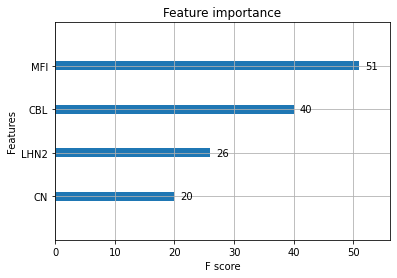

In [6]:
xgb.plot_importance(models['xgb']).set_yticklabels(['CN','LHN2', 'CBL', 'MFI'])

In [7]:
df2 = similarity_indices(G)

0.013441106338565096


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/content/auc_all_methods.py:243: RuntimeWarning: invalid value encountered in sqrt
  edgesWithScore[e] = float(sim[x][y])/np.sqrt(sim[x][x] * sim[y][y])


In [8]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
y_pred_stack = models['stacking'].predict(X_test)
y_pred_xgb = models['xgb'].predict(X_test)
y_pred_lr = models['lr'].predict(X_test)
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred_lr)
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred_xgb)
fpr3, tpr3, thresholds3 = roc_curve(y_test, y_pred_stack)
fpr4, tpr4, thresholds4 = precision_recall_curve(y_test, y_pred_lr)
fpr5, tpr5, thresholds5 = precision_recall_curve(y_test, y_pred_xgb)
fpr6, tpr6, thresholds6 = precision_recall_curve(y_test, y_pred_stack)

In [9]:
accuracy_score(y_test, y_pred_lr).round()

1.0

In [10]:
auc(fpr4, tpr4)

0.4837085606273593

In [11]:
# df2['lr'] = [auc(fpr1, tpr1),accuracy_score(y_test, y_pred_lr), float(auc(fpr4, tpr4))]
df2['xgb'] = [auc(fpr2, tpr2),accuracy_score(y_test, y_pred_xgb), auc(fpr5, tpr5)]
df2['ensemble'] = [auc(fpr3, tpr3),accuracy_score(y_test, y_pred_stack), auc(fpr6, tpr6)]

In [12]:
import pandas as pd
df3 = pd.DataFrame(columns = ['accuracy', 'auc', 'precision', 'recall', 'f1', 'roc', 'aupr'])
df3.loc['lr'] = [accuracy_score(y_test, y_pred_lr),auc(fpr1, tpr1), precision_score( y_test, y_pred_lr), recall_score( y_test, y_pred_lr), f1_score( y_test, y_pred_lr), roc_auc_score( y_test, y_pred_lr), auc(fpr4, tpr4) ]
df3.loc['xgb'] = [accuracy_score(y_test, y_pred_xgb),auc(fpr2, tpr2), precision_score( y_test, y_pred_xgb), recall_score( y_test, y_pred_xgb), f1_score( y_test, y_pred_xgb), roc_auc_score( y_test, y_pred_xgb) , auc(fpr5, tpr5)]
df3.loc['ensemble'] = [accuracy_score(y_test, y_pred_stack),auc(fpr3, tpr3), precision_score( y_test, y_pred_stack), recall_score( y_test, y_pred_stack), f1_score( y_test, y_pred_stack), roc_auc_score( y_test, y_pred_stack), auc(fpr6, tpr6) ]

In [13]:
import pandas as pd
pd.set_option("display.max_rows", 4, "display.max_columns", 14)
print(df2)

                cn   jaccard      lhn1      katz  lhn2       cbl       mfi  \
auc       0.956214  0.917105  0.792196  0.942298   NaN  0.910735  0.941264   
accuracy  0.967685  0.917761  0.792698  0.942298   NaN  0.910735  0.941265   
aupr      0.976266  0.998568  0.998733  0.999999   NaN  1.000000  0.999997   

          localpath        l3       xgb  ensemble  
auc        0.947080  0.134214  0.998432  0.997632  
accuracy   0.947613  0.135630  0.998433  0.997649  
aupr       0.998864  0.979331  0.488668  0.487902  


In [14]:
import pandas as pd
pd.set_option("display.max_rows", 4, "display.max_columns", 14)
print(df3)

          accuracy       auc  precision    recall        f1       roc  \
lr        0.991379  0.991392   0.992308  0.990783  0.991545  0.991392   
xgb       0.998433  0.998432   0.998464  0.998464  0.998464  0.998432   
ensemble  0.997649  0.997632   0.996933  0.998464  0.997698  0.997632   

              aupr  
lr        0.483709  
xgb       0.488668  
ensemble  0.487902  


In [15]:
with pd.ExcelWriter('output.xlsx') as writer:  
    df2.to_excel(writer, sheet_name='similarity')
    df3.to_excel(writer, sheet_name='eval_metric')